# ASSIGNMENT 1

### Imports

In [1]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB, BernoulliNB
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (accuracy_score, confusion_matrix,
                             classification_report, roc_curve, auc,
                             precision_recall_curve)
from sklearn.model_selection import GridSearchCV, learning_curve
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
from tqdm import tqdm

### Model Selection

- Uses **TF-IDF vectorization** for text feature extraction.  
- Implements multiple **ML models** (Naive Bayes, SVM, Logistic Regression, Neural Network, Random Forest).  
- Optimizes models using **GridSearchCV** for hyperparameter tuning.  
- Evaluates models with **accuracy, confusion matrix, ROC, and Precision-Recall curves**.  
- Checks for **overfitting/underfitting** using learning curves and score comparison.  
- Analyzes **data drift** between training and test sets.  
- Selects the **best model**, saves it, and ranks all models based on performance.

In [2]:
class ModelTraining:
    def __init__(self):
        self.vectorizer = TfidfVectorizer(
            max_features=3000,
            ngram_range=(1, 2),
            stop_words='english',
            strip_accents='unicode',
            preprocessor=str,
            min_df=3,
            max_df=0.9
        )

        self.models = {
            'naive_bayes': {
                'model': MultinomialNB(),
                'params': {
                    'classifier__alpha': [0.5, 1.0, 2.0],
                }
            },
            'bernoulli_nb': {
                'model': BernoulliNB(),
                'params': {
                    'classifier__alpha': [0.5, 1.0, 2.0],
                }
            },
            'svm_rbf': {
                'model': SVC(random_state=42, probability=True),
                'params': {
                    'classifier__C': [0.5, 1.0],
                    'classifier__gamma': ['scale', 'auto'],
                    'classifier__kernel': ['rbf'],
                    'classifier__class_weight': ['balanced']
                }
            },
            'logistic_regression': {
                'model': LogisticRegression(random_state=42),
                'params': {
                    'classifier__C': [0.1, 0.5, 1.0],
                    'classifier__solver': ['liblinear'],
                    'classifier__class_weight': ['balanced'],
                    'classifier__penalty': ['l1', 'l2']
                }
            },
            'neural_network': {
                'model': MLPClassifier(random_state=42),
                'params': {
                    'classifier__hidden_layer_sizes': [(32,), (64,), (128,), (32, 16), (64, 32)],
                    'classifier__activation': ['relu', 'tanh'],
                    'classifier__alpha': [0.0001, 0.001, 0.01, 0.1],
                    'classifier__learning_rate': ['constant', 'adaptive'],
                    'classifier__early_stopping': [True, False],
                    'classifier__validation_fraction': [0.1, 0.2],
                    'classifier__max_iter': [300, 500]
                }
            },
            'random_forest': {
                'model': RandomForestClassifier(random_state=42),
                'params': {
                    'classifier__n_estimators': [100, 200],
                    'classifier__max_depth': [10, 20, 30, 50, 100],
                    'classifier__min_samples_split': [2, 5, 10],
                    'classifier__min_samples_leaf': [1, 2, 4],
                    'classifier__max_features': ['sqrt', 'log2'],
                    'classifier__bootstrap': [True, False],
                    'classifier__class_weight': ['balanced', 'balanced_subsample']
                }
            },
        }

        self.best_model = None
        self.best_score = 0

    def create_pipeline(self, model):
        """Create a pipeline with TF-IDF and model"""

        return Pipeline([
            ('tfidf', self.vectorizer),
            ('classifier', model)
        ])

    def plot_learning_curves(self, estimator, X, y, title):
        train_sizes, train_scores, val_scores = learning_curve(
            estimator, X, y, cv=5, n_jobs=-1,
            train_sizes=np.linspace(0.1, 1.0, 10)
        )

        plt.figure(figsize=(10, 6))
        plt.plot(train_sizes, np.mean(train_scores, axis=1), label='Training score')
        plt.plot(train_sizes, np.mean(val_scores, axis=1), label='Cross-validation score')
        plt.xlabel('Training examples')
        plt.ylabel('Score')
        plt.title(f'Learning Curves - {title}')
        plt.legend(loc='best')
        plt.grid(True)
        plt.show()

    def plot_roc_curve(self, model, X, y, title):
        """Plot ROC curve"""
        try:
            if not hasattr(model, "predict_proba"):
                print(f"Warning: {type(model).__name__} doesn't support predict_proba")
                return

            y = y.astype(int)
            y_score = model.predict_proba(X)[:, 1]

            fpr, tpr, _ = roc_curve(y, y_score)
            roc_auc = auc(fpr, tpr)

            plt.figure(figsize=(10, 6))
            plt.plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc:.2f})')
            plt.plot([0, 1], [0, 1], 'k--')
            plt.xlabel('False Positive Rate')
            plt.ylabel('True Positive Rate')
            plt.title(f'ROC Curve - {title}')
            plt.legend(loc='best')
            plt.grid(True)
            plt.show()
        except Exception as e:
            print(f"Could not generate ROC curve for {title}: {str(e)}")

    def plot_precision_recall_curve(self, model, X, y, title):
        """Plot precision-recall curve"""
        try:
            if not hasattr(model, "predict_proba"):
                print(f"Warning: {type(model).__name__} doesn't support predict_proba")
                return

            y = y.astype(int)
            y_score = model.predict_proba(X)[:, 1]

            precision, recall, _ = precision_recall_curve(y, y_score)

            plt.figure(figsize=(10, 6))
            plt.plot(recall, precision)
            plt.xlabel('Recall')
            plt.ylabel('Precision')
            plt.title(f'Precision-Recall Curve - {title}')
            plt.grid(True)
            plt.show()
        except Exception as e:
            print(f"Could not generate Precision-Recall curve for {title}: {str(e)}")

    def evaluate_model(self, pipeline, X, y, dataset_name=""):
        """Enhanced model evaluation"""
        try:
            y = pd.Series(y).astype(int)

            y_pred = pipeline.predict(X)

            accuracy = accuracy_score(y, y_pred)
            report = classification_report(y, y_pred,
                                           target_names=['ham', 'spam'],
                                           output_dict=True)

            # Plot confusion matrix
            plt.figure(figsize=(10, 8))
            cm = confusion_matrix(y, y_pred)
            cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
            sns.heatmap(cm_normalized, annot=True, fmt='.2%', cmap='Blues',
                        xticklabels=['ham', 'spam'],
                        yticklabels=['ham', 'spam'])
            plt.title(f'Normalized Confusion Matrix - {dataset_name}')
            plt.ylabel('True Label')
            plt.xlabel('Predicted Label')
            plt.show()

            # If pipeline supports predict_proba, plot ROC & PR curves
            if hasattr(pipeline, 'predict_proba'):
                self.plot_roc_curve(pipeline, X, y, dataset_name)
                self.plot_precision_recall_curve(pipeline, X, y, dataset_name)

            print(f"\nResults on {dataset_name} set:")
            print(f"Accuracy: {accuracy:.4f}")
            print("\nClassification Report:")
            print(classification_report(y, y_pred))

            return accuracy
        except Exception as e:
            print(f"Error in model evaluation: {str(e)}")
            raise

    def analyze_data_drift(self, train_df, test_df):
        print("\nAnalyzing data drift...")
        train_lengths = train_df['processed_text'].str.len()
        test_lengths = test_df['processed_text'].str.len()

        plt.figure(figsize=(10, 6))
        plt.hist(train_lengths, alpha=0.5, label='Train', density=True)
        plt.hist(test_lengths, alpha=0.5, label='Test', density=True)
        plt.title('Text Length Distribution: Train vs Test')
        plt.legend()
        plt.show()

        train_vocab = set(' '.join(train_df['processed_text']).split())
        test_vocab = set(' '.join(test_df['processed_text']).split())
        vocab_overlap = len(train_vocab.intersection(test_vocab)) / len(train_vocab) if len(train_vocab) > 0 else 0
        print(f"Vocabulary overlap between train and test: {vocab_overlap:.2%}")

    def check_model_fit(self, model, X_train, y_train, X_test, y_test):
        train_score = model.score(X_train, y_train)
        test_score = model.score(X_test, y_test)

        print("\nModel Fit Analysis:")
        print(f"Train score: {train_score:.4f}")
        print(f"Test score: {test_score:.4f}")

        if test_score < train_score * 0.9:
            print("Warning: Possible overfitting - test score significantly lower than train score")
        elif train_score < 0.6 and test_score < 0.6:
            print("Warning: Possible underfitting - both train and test scores are low")

        self.plot_learning_curves(model, X_train, y_train, "fit_analysis")

    def train_and_evaluate(self, train_df, val_df, test_df):
        print("Training and evaluating models...")

        combined_df = pd.concat([train_df, val_df], ignore_index=True)
        print(f"\nCombined training set size: {len(combined_df)} samples")

        for df, name in [(combined_df, 'training'), (test_df, 'test')]:
            if 'processed_text' not in df.columns or 'label' not in df.columns:
                raise ValueError(f"Missing required columns in {name} data")

            df['processed_text'] = df['processed_text'].fillna('').astype(str)

            # Convert ham/spam to 0/1 if still strings
            if df['label'].dtype == object:
                print(f"\nConverting labels in {name} set...")
                df['label'] = df['label'].map({'ham': 0, 'spam': 1})
                if df['label'].isna().any():
                    raise ValueError(f"Invalid labels found in {name} data")

            if not set(df['label'].unique()).issubset({0, 1}):
                raise ValueError(f"Invalid label values in {name} data: {df['label'].unique()}")

        n_neg = len(combined_df[combined_df['label'] == 0])
        n_pos = len(combined_df[combined_df['label'] == 1])
        scale_pos_weight = n_neg / n_pos if n_pos > 0 else 1.0
        print(f"\nClass imbalance ratio (ham/spam): {scale_pos_weight:.2f}")

        results = {}

        for model_name, model_info in tqdm(self.models.items()):
            print(f"\nTraining {model_name}...")
            try:
                pipeline = self.create_pipeline(model_info['model'])

                grid_search = GridSearchCV(
                    pipeline,
                    model_info['params'],
                    cv=5,
                    scoring='accuracy',
                    n_jobs=-1
                )

                grid_search.fit(combined_df['processed_text'], combined_df['label'])

                best_pipeline = grid_search.best_estimator_

                train_score = self.evaluate_model(
                    best_pipeline,
                    combined_df['processed_text'],
                    combined_df['label'],
                    f"{model_name}_training"
                )

                test_score = self.evaluate_model(
                    best_pipeline,
                    test_df['processed_text'],
                    test_df['label'],
                    f"{model_name}_test"
                )

                self.plot_learning_curves(
                    best_pipeline,
                    combined_df['processed_text'],
                    combined_df['label'],
                    model_name
                )

                results[model_name] = {
                    'pipeline': best_pipeline,
                    'best_params': grid_search.best_params_,
                    'cv_scores': grid_search.cv_results_['mean_test_score'],
                    'train_score': train_score,
                    'test_score': test_score
                }

                if test_score > self.best_score:
                    self.best_score = test_score
                    self.best_model = best_pipeline
                    self.best_model_name = model_name

                joblib.dump(best_pipeline, f"{model_name}_model.pkl")

                self.check_model_fit(
                    best_pipeline,
                    combined_df['processed_text'],
                    combined_df['label'],
                    test_df['processed_text'],
                    test_df['label']
                )

            except Exception as e:
                print(f"\nError training {model_name}: {str(e)}")
                continue

        print("\nModel Performance Summary:")
        summary_data = []
        for model_name, result in results.items():
            summary_data.append({
                'Model': model_name,
                'Train Accuracy': result['train_score'],
                'Test Accuracy': result['test_score'],
            })

        summary_df = pd.DataFrame(summary_data)
        summary_df = summary_df.sort_values('Test Accuracy', ascending=False)
        print("\nModel Rankings (sorted by test accuracy):")
        print(summary_df.to_string(index=False))

        joblib.dump(self.best_model, "final_model.pkl")
        print(f"\nBest model ({self.best_model_name}) saved as 'final_model.pkl'")
        print(f"Best test accuracy: {self.best_score:.4f}")

        # Optional: Data drift analysis
        self.analyze_data_drift(train_df, test_df)

In [3]:
# Load the prepared data
train_df = pd.read_csv('train.csv')
val_df = pd.read_csv('validation.csv')
test_df = pd.read_csv('test.csv')

# Initialize and run training
trainer = ModelTraining()

In [ ]:
trainer.train_and_evaluate(train_df, val_df, test_df)

print("\nTraining completed!")

### Conclusion

- Best model naive_bayes
- Best test accuracy: 0.99

# ASSIGNMENT 2

In [ ]:
# remember to run below command to start mlflow server
# mlflow server --host 127.0.0.1 --port 8080


Training and tracking naive_bayes with MLflow...


/home/dhruv/miniconda3/envs/llm/lib/python3.11/site-packages/mlflow/types/utils.py:452: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(


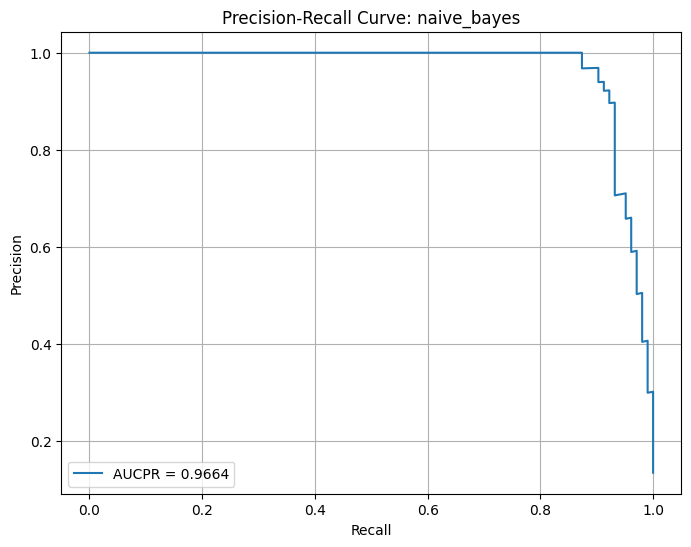

Registered model 'spam_classifier_naive_bayes' already exists. Creating a new version of this model...
2025/02/28 21:39:51 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: spam_classifier_naive_bayes, version 2
Created version '2' of model 'spam_classifier_naive_bayes'.
/tmp/ipykernel_113424/2532926871.py:95: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  model_results_df = pd.concat([model_results_df,


🏃 View run benchmark_naive_bayes at: http://localhost:8080/#/experiments/871671888556955392/runs/a78f256d3035498daa3e1ed9a34089d7
🧪 View experiment at: http://localhost:8080/#/experiments/871671888556955392

Training and tracking logistic_regression with MLflow...


/home/dhruv/miniconda3/envs/llm/lib/python3.11/site-packages/mlflow/types/utils.py:452: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(


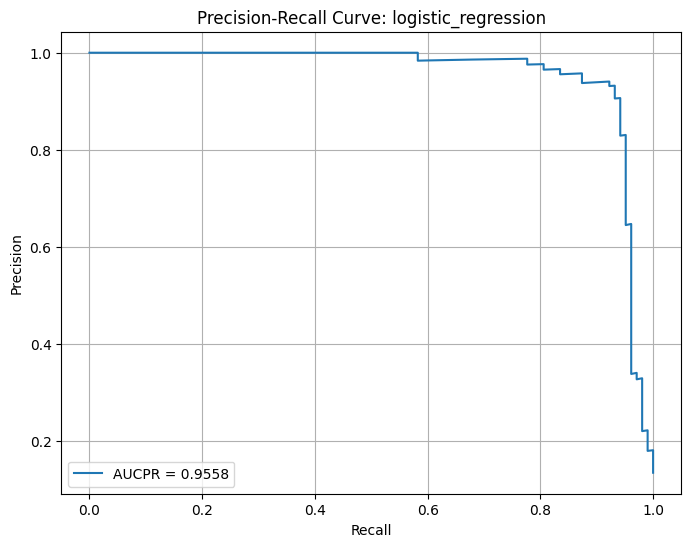

Registered model 'spam_classifier_logistic_regression' already exists. Creating a new version of this model...
2025/02/28 21:39:55 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: spam_classifier_logistic_regression, version 2
Created version '2' of model 'spam_classifier_logistic_regression'.


🏃 View run benchmark_logistic_regression at: http://localhost:8080/#/experiments/871671888556955392/runs/6ed7a04263e3498b843d48cebf77b115
🧪 View experiment at: http://localhost:8080/#/experiments/871671888556955392

Training and tracking svm with MLflow...


/home/dhruv/miniconda3/envs/llm/lib/python3.11/site-packages/mlflow/types/utils.py:452: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(


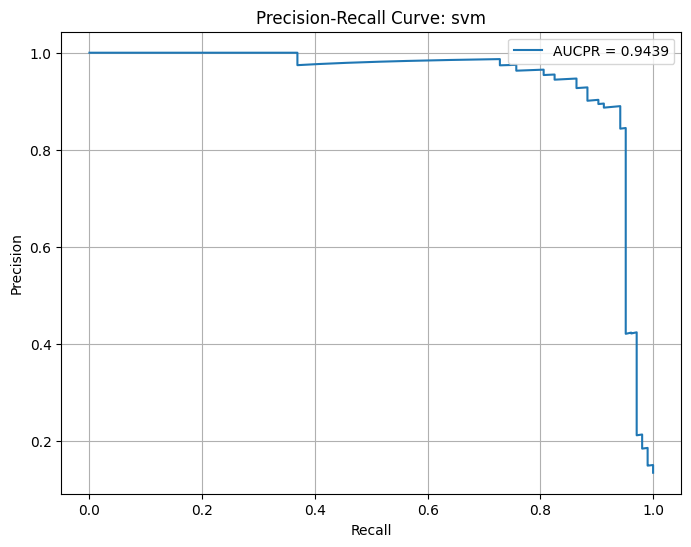

Successfully registered model 'spam_classifier_svm'.
2025/02/28 21:39:59 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: spam_classifier_svm, version 1
Created version '1' of model 'spam_classifier_svm'.


🏃 View run benchmark_svm at: http://localhost:8080/#/experiments/871671888556955392/runs/39ed9d9e5823420aac4b84b052287976
🧪 View experiment at: http://localhost:8080/#/experiments/871671888556955392

=== Benchmark Models Comparison ===
              Model   AUC-PR  Accuracy  F1-Score
        naive_bayes 0.966384  0.983051  0.932642
logistic_regression 0.955771  0.981747  0.932039
                svm 0.943909  0.975228  0.903553


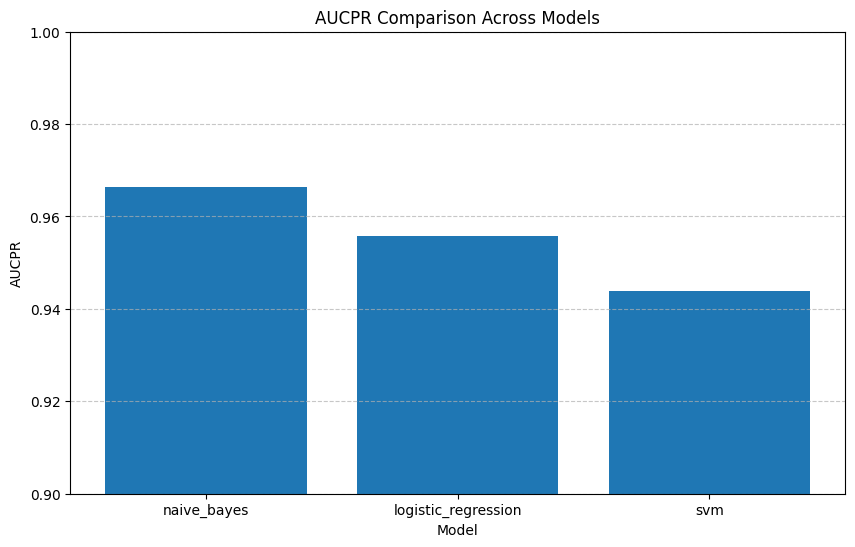


Best Model based on AUC-PR: naive_bayes with AUCPR = 0.9664

MLflow tracking and model registration complete!


In [8]:
# Add MLflow integration
import mlflow
import mlflow.sklearn
from sklearn.metrics import auc, precision_recall_curve, f1_score
from mlflow.models.signature import infer_signature
import matplotlib.pyplot as plt

# Set up MLflow tracking
mlflow.set_tracking_uri("http://localhost:8080")
mlflow.set_experiment("SMS Spam Classification")

# Define the benchmark models to track with optimized parameters from Assignment 1
benchmark_models = {
    'naive_bayes': MultinomialNB(alpha=0.05),
    'logistic_regression': LogisticRegression(C=50, class_weight='balanced', random_state=42),
    'svm': SVC(C=5, gamma='scale', kernel='linear', random_state=42, probability=True)
}

# Function to plot and calculate AUCPR
def plot_aucpr(y_true, y_pred_proba, model_name):
    precision, recall, _ = precision_recall_curve(y_true, y_pred_proba)
    aucpr = auc(recall, precision)
    
    plt.figure(figsize=(8, 6))
    plt.plot(recall, precision, label=f'AUCPR = {aucpr:.4f}')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title(f'Precision-Recall Curve: {model_name}')
    plt.legend()
    plt.grid(True)
    plt.show()
    
    return aucpr

# Train and register benchmark models with MLflow
registered_models = {}
model_results_df = pd.DataFrame(columns=['Model', 'AUC-PR', 'Accuracy', 'F1-Score'])

for model_name, model in benchmark_models.items():
    print(f"\nTraining and tracking {model_name} with MLflow...")
    
    with mlflow.start_run(run_name=f"benchmark_{model_name}"):
        # Create and train pipeline
        pipeline = Pipeline([
            ('tfidf', trainer.vectorizer),
            ('classifier', model)
        ])
        
        pipeline.fit(train_df['processed_text'], train_df['label'])
        
        # Evaluate on test set
        y_test_pred = pipeline.predict(test_df['processed_text'])
        test_accuracy = accuracy_score(test_df['label'], y_test_pred)
        f1 = f1_score(test_df['label'], y_test_pred)
        
        # Calculate AUCPR (Area Under Precision-Recall Curve)
        y_test_proba = pipeline.predict_proba(test_df['processed_text'])[:, 1]
        
        # Create signature for model
        signature = infer_signature(test_df['processed_text'], test_df['label'])
        
        # Plot AUCPR curve
        aucpr = plot_aucpr(test_df['label'], y_test_proba, model_name)
        
        # Log parameters and metrics
        if model_name == 'naive_bayes':
            mlflow.log_param("model_name", "Multinomial NB Model")
        elif model_name == 'logistic_regression':
            mlflow.log_param("model_name", "Logistic Regression Model")
        else:
            mlflow.log_param("model_name", "Support Vector Machines Model")
            
        mlflow.log_params(model.get_params())
        mlflow.log_metric("AUC-PR", aucpr)
        mlflow.log_metric("Accuracy", test_accuracy)
        mlflow.log_metric("F1-Score", f1)
        
        # Log the model with signature
        registered_model_name = f"spam_classifier_{model_name}"
        mlflow.sklearn.log_model(
            pipeline, 
            "sklearn-model",
            signature=signature,
            registered_model_name=registered_model_name
        )
        
        # Store model info for later comparison
        registered_models[model_name] = {
            "accuracy": test_accuracy,
            "aucpr": aucpr,
            "f1": f1
        }
        
        # Add to results dataframe
        model_results_df = pd.concat([model_results_df, 
                                     pd.DataFrame({'Model': [model_name], 
                                                  'AUC-PR': [aucpr], 
                                                  'Accuracy': [test_accuracy],
                                                  'F1-Score': [f1]})], 
                                    ignore_index=True)

# Print metrics for all benchmark models
print("\n=== Benchmark Models Comparison ===")
print(model_results_df.to_string(index=False))

# Plot comparison of AUCPR values
plt.figure(figsize=(10, 6))
plt.bar(model_results_df['Model'], model_results_df['AUC-PR'])
plt.title('AUCPR Comparison Across Models')
plt.xlabel('Model')
plt.ylabel('AUCPR')
plt.ylim(0.9, 1.0)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

# Identify best model based on AUCPR
best_model = model_results_df.loc[model_results_df['AUC-PR'].idxmax()]
print(f"\nBest Model based on AUC-PR: {best_model['Model']} with AUCPR = {best_model['AUC-PR']:.4f}")

print("\nMLflow tracking and model registration complete!")